In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy import stats
from scipy.stats import qmc
from concurrent.futures import ThreadPoolExecutor
import seaborn as sns
from sympy import prevprime
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LinearSegmentedColormap

In [2]:
def seed():
    np.random.seed(42)

seed()

In [3]:
np.diff(np.array([0,1,5,7,10]))

array([1, 4, 2, 3])

# Q1.Implement and visualize Mandelbrot set

In [4]:
class Mandelbrot():

    def __converges(self, cs, i_list: np.array):
        i_list_sorted = np.sort(i_list)
        num_i = len(i_list_sorted)
        num_s = len(cs)

        z = np.zeros(num_s, dtype=np.complex64)
        escape_times_i_list = np.zeros((num_i, num_s), dtype=np.uint16)
        conv_i_list = np.ones((num_i, num_s), dtype=bool)

        if num_i > 1:
            i_maxs = np.zeros(num_i, dtype=np.uint16)
            i_maxs[0] = i_list_sorted[0]
            i_maxs[1:] = np.round(np.diff(i_list_sorted))
        else: 
            i_maxs = i_list_sorted

        for idx in range(num_i):
            escape_times_i_list[idx] = escape_times_i_list[idx-1] if idx > 0 else escape_times_i_list[idx]
            conv_i_list[idx] = conv_i_list[idx-1] if idx > 0 else conv_i_list[idx]
            for _ in range(i_maxs[idx]):
                z[conv_i_list[idx]] = z[conv_i_list[idx]]**2 + cs[conv_i_list[idx]]
                mask_conv = (np.abs(z) > 2)
                conv_i_list[idx, mask_conv] = False
                escape_times_i_list[idx, conv_i_list[idx]] += 1

        return conv_i_list, escape_times_i_list

    def __get_rand_dist(self, num_points):
        """Generates random complex numbers with absolute value smaller or equal to 2, i.e. sample from the circle with radius 2."""
        grid = 2 * np.sqrt(np.random.uniform(size=num_points)) * np.exp(1.j * 2 * np.pi * np.random.uniform(size=num_points))
        
        return grid.astype(np.complex64)

    def __get_rand_LHS(self, num_points): 
        """Generates random complex numbers with LHS method"""
        samples = qmc.LatinHypercube(d=2, strength=1).random(n=num_points)
        grid = 2 * np.sqrt(samples[:,0]) * np.exp(1.j * 2 * np.pi * samples[:,1])

        return grid.astype(np.complex64)
    
    def __get_rand_Orth(self, num_points): 
        """Generates random complex numbers with Orth method"""
        sampler = qmc.LatinHypercube(d=2, strength=2).random(n=num_points)
        grid = 2 * np.sqrt(sampler[:,0]) * np.exp(1.j * 2 * np.pi * sampler[:,1])

        return grid.astype(np.complex64)
    
    def get_escape_time(self, num_points, i_list: np.array):
        grid = self.__get_rand_dist(num_points)
        conv_i_list, escape_times_i_list = self.__converges(grid, i_list)

        return grid, conv_i_list, escape_times_i_list
    
    def get_escape_time_LHS(self, num_points, i_list: np.array):
        grid = self.__get_rand_LHS(num_points)
        conv_i_list, escape_times_i_list = self.__converges(grid, i_list)

        return grid, conv_i_list, escape_times_i_list
    
    def get_escape_time_Orth(self, num_points, i_list: np.array):
        grid = self.__get_rand_Orth(num_points)
        conv_i_list, escape_times_i_list = self.__converges(grid, i_list)

        return grid, conv_i_list, escape_times_i_list
    
    def get_MC(self, converges):
        MC_list = converges.sum(axis=-1) / np.size(converges, axis=-1) * np.pi * 4

        return MC_list

In [29]:
mandelbrot = Mandelbrot()
num_points = 10**7
max_iter = np.array([3000])
grid_draw, converges_draw, escape_times_draw = mandelbrot.get_escape_time(num_points, max_iter)
mandelbrot.get_MC(converges_draw)

array([1.50951768])

In [32]:
def has_no_converging_points(grid, converges, r, real_part):
    if real_part:
        condition = np.real(grid) > r
    else:
        condition = np.abs(np.imag(grid)) > r
    
    converging_points = np.logical_and(condition, converges)
    has_no_conv_points = not np.any(converging_points)
    
    if real_part:
        conv_bound = f'Real(c) > {r}'
    else:
        conv_bound = f'Im(c) > {r}'

    print(f'The statement when {conv_bound} there is a c in the Mandelbrot set is {has_no_conv_points}')

has_no_converging_points(grid_draw, converges_draw, 0.5, True)
has_no_converging_points(grid_draw, converges_draw, 1.15, False)

The statement when Real(c) > 0.5 there is a c in the Mandelbrot set is True
The statement when Im(c) > 1.15 there is a c in the Mandelbrot set is True


In [33]:
def plot_Mandelbrot(grid, escape_times):
    sns.set(style='whitegrid')
    colors = ['#00008B', 'white', 'black']
    cmap = LinearSegmentedColormap.from_list('blue_white_black', colors)

    fig, ax = plt.subplots(figsize=(10, 10), dpi=500)

    # Set only the plot area background to blue
    ax.set_facecolor('#00008B')
    
    ax.scatter(np.real(grid), np.imag(grid), c=np.log(escape_times), cmap=cmap, s=0.01)
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])

    def format_func(value, tick_number):
        return f'{value}i'

    ax.yaxis.set_major_formatter(FuncFormatter(format_func))

    ax.axvline(x=0.5, color='r', linestyle='--')
    ax.axhline(y=1.15, color='g', linestyle='--')
    ax.axhline(y=-1.15, color='b', linestyle='--')

    ax.set_xlabel('Re')
    ax.set_ylabel('Im')

    ax.set_title(f'Mandelbrot Set with {len(grid)} Uniform Points')
    ax.grid(False)

    plt.savefig(f'figures/Mandelbrot.png')

    plt.show()


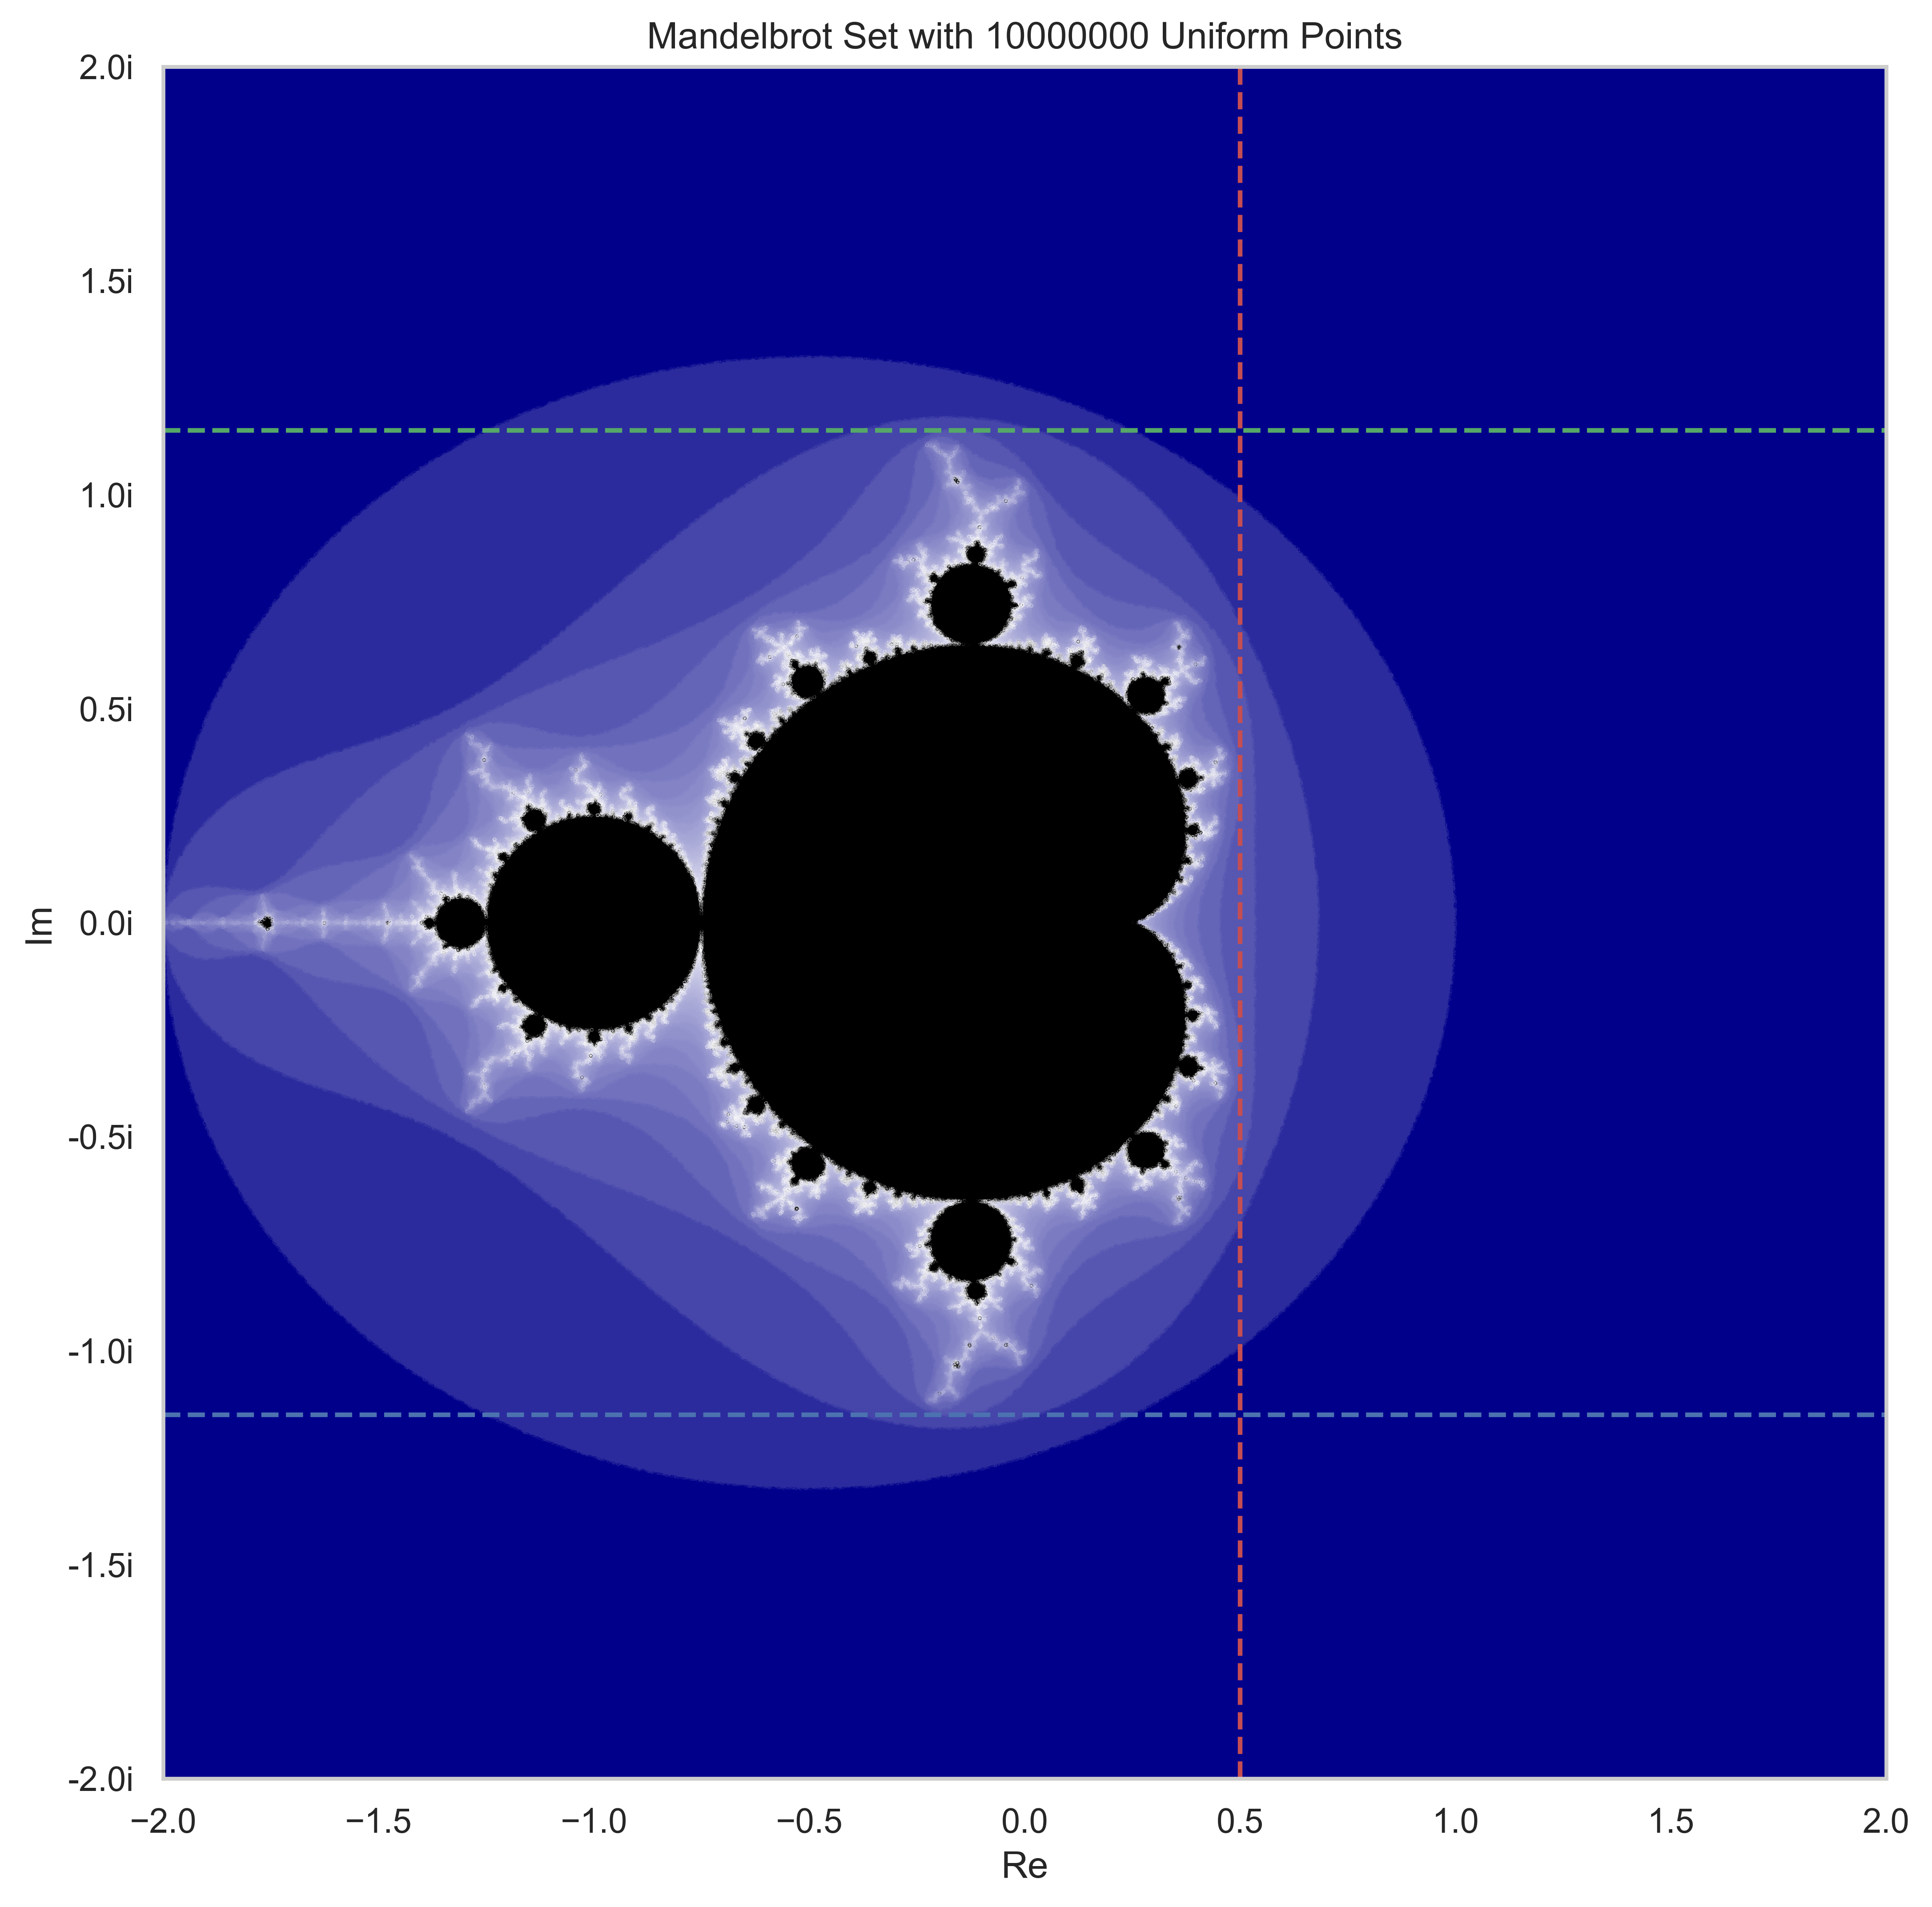

In [36]:
plot_Mandelbrot(grid_draw, escape_times_draw)

# Q2.Investigate the convergence

In [7]:
def get_data_rs(num_mc, i_list=None, s_list=None, save_file=None, load_file=None, num_threads=None):
    seed()

    num_i = len(i_list)
    num_s = len(s_list)

    if load_file:
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_areas_{num_mc}_random.npy', 'rb') as f:
            areas = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_sd_{num_mc}_random.npy', 'rb') as f:
            sd = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_upper_{num_mc}_random.npy', 'rb') as f:
            upper_ci = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_lower_{num_mc}_random.npy', 'rb') as f:
            lower_ci = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_converges_{num_mc}_random.npy', 'rb') as f:
            converges_i_list = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_grid_{num_mc}_random.npy', 'rb') as f:
            grid = np.load(f)

        return areas, sd, upper_ci, lower_ci, converges_i_list, grid
        
    if i_list is None or s_list is None:
        raise ValueError()

    mandelbrot = Mandelbrot()
    areas = np.zeros((num_i, num_s))
    sd = np.zeros((num_i, num_s))
    upper_ci = np.zeros((num_i, num_s))
    lower_ci = np.zeros((num_i, num_s))

    max_s = np.max(s_list)
    mc_data = None
    grid, converges_i_list, _ = mandelbrot.get_escape_time(max_s*num_mc, i_list)
    if save_file:
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_converges_{num_mc}_random.npy', 'wb') as f:
            np.save(f, converges_i_list)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_grid_{num_mc}_random.npy', 'wb') as f:
            np.save(f, grid)

        
    margin_tbm = stats.t.ppf(0.975, num_mc-1)/np.sqrt(num_mc)

    for s_idx, s in enumerate(s_list):
        with ThreadPoolExecutor(max_workers=num_threads) as ex:
            mc_data = list(ex.map(mandelbrot.get_MC, [converges_i_list[:, s*num:s*(num+1)] for num in np.arange(num_mc)]))

        sd[:, s_idx] = np.std(mc_data, ddof=1, axis=0)
        margin = margin_tbm*sd[:, s_idx]
        areas[:,s_idx] = np.mean(mc_data, axis=0)
        upper_ci[:,s_idx] = areas[:,s_idx] + margin
        lower_ci[:,s_idx] = areas[:,s_idx] - margin
    
    if save_file:
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_areas_{num_mc}_random.npy', 'wb') as f:
            np.save(f, areas)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_sd_{num_mc}_random.npy', 'wb') as f:
            np.save(f, sd)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_upper_{num_mc}_random.npy', 'wb') as f:
            np.save(f, upper_ci)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_lower_{num_mc}_random.npy', 'wb') as f:
            np.save(f, lower_ci)
    return areas, sd, upper_ci, lower_ci, converges_i_list, grid

def get_data_LHS(num_mc, i_list=None, s_list=None, save_file=None, load_file=None, num_threads=None):
    seed()

    num_i = len(i_list)
    num_s = len(s_list)

    if load_file:
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_areas_{num_mc}_LHS.npy', 'rb') as f:
            areas = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_sd_{num_mc}_LHS.npy', 'rb') as f:
            sd = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_upper_{num_mc}_LHS.npy', 'rb') as f:
            upper_ci = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_lower_{num_mc}_LHS.npy', 'rb') as f:
            lower_ci = np.load(f)

        return areas, sd, upper_ci, lower_ci

    if i_list is None or s_list is None:
        raise ValueError()

    mandelbrot = Mandelbrot()
    areas = np.zeros((num_i, num_s))
    sd = np.zeros((num_i, num_s))
    upper_ci = np.zeros((num_i, num_s))
    lower_ci = np.zeros((num_i, num_s))

    converges_n_i_list = None

    margin_tbm = stats.t.ppf(0.975, num_mc-1)/np.sqrt(num_mc)

    for s_idx, s in enumerate(s_list):
        with ThreadPoolExecutor(max_workers=num_threads) as ex:
            converges_n_i_list = np.array(list(ex.map(lambda i: mandelbrot.get_escape_time_LHS(s, i)[1], [i_list for _ in range(num_mc)])))

        mc_data = mandelbrot.get_MC(converges_n_i_list)

        sd[:, s_idx] = np.std(mc_data, ddof=1, axis=0)
        margin = margin_tbm*sd[:, s_idx]
        areas[:,s_idx] = np.mean(mc_data, axis=0)
        upper_ci[:,s_idx] = areas[:,s_idx] + margin
        lower_ci[:,s_idx] = areas[:,s_idx] - margin
    
    if save_file:
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_areas_{num_mc}_LHS.npy', 'wb') as f:
            np.save(f, areas)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_sd_{num_mc}_LHS.npy', 'wb') as f:
            np.save(f, sd)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_upper_{num_mc}_LHS.npy', 'wb') as f:
            np.save(f, upper_ci)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_lower_{num_mc}_LHS.npy', 'wb') as f:
            np.save(f, lower_ci)
    return areas, sd, upper_ci, lower_ci

def get_data_Orth(num_mc, i_list=None, s_list=None, save_file=None, load_file=None, num_threads=None):

    def get_prev_square_prime(n):
        return prevprime(np.sqrt(n))**2

    seed()

    num_i = len(i_list)
    num_s = len(s_list)

    if load_file:
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_areas_{num_mc}_Orth.npy', 'rb') as f:
            areas = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_sd_{num_mc}_Orth.npy', 'rb') as f:
            sd = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_upper_{num_mc}_Orth.npy', 'rb') as f:
            upper_ci = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_lower_{num_mc}_Orth.npy', 'rb') as f:
            lower_ci = np.load(f)

        return areas, sd, upper_ci, lower_ci

    if i_list is None or s_list is None:
        raise ValueError()

    mandelbrot = Mandelbrot()
    areas = np.zeros((num_i, num_s))
    sd = np.zeros((num_i, num_s))
    upper_ci = np.zeros((num_i, num_s))
    lower_ci = np.zeros((num_i, num_s))
    converges_n_i_list = None

    margin_tbm = stats.t.ppf(0.975, num_mc-1)/np.sqrt(num_mc)

    for s_idx, s in enumerate(s_list):
        prev_square_prime_s = get_prev_square_prime(s)

        with ThreadPoolExecutor(max_workers=num_threads) as ex:
            converges_n_i_list = \
                np.array(list(ex.map(lambda i: mandelbrot.get_escape_time_Orth(prev_square_prime_s, i)[1], [i_list for _ in range(num_mc)])))

        mc_data = mandelbrot.get_MC(converges_n_i_list)

        sd[:, s_idx] = np.std(mc_data, ddof=1, axis=0)
        margin = margin_tbm*sd[:, s_idx]
        areas[:,s_idx] = np.mean(mc_data, axis=0)
        upper_ci[:,s_idx] = areas[:,s_idx] + margin
        lower_ci[:,s_idx] = areas[:,s_idx] - margin
    
    if save_file:
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_areas_{num_mc}_Orth.npy', 'wb') as f:
            np.save(f, areas)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_sd_{num_mc}_Orth.npy', 'wb') as f:
            np.save(f, sd)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_upper_{num_mc}_Orth.npy', 'wb') as f:
            np.save(f, upper_ci)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_lower_{num_mc}_Orth.npy', 'wb') as f:
            np.save(f, lower_ci)
    return areas, sd, upper_ci, lower_ci

In [ ]:
def plot_heatmap(X, Y, areas, true_area, fig_filename):
    plt.figure(figsize=(9, 7))
    heatmap = plt.contourf(X, Y, np.abs(areas-true_area), cmap='RdYlGn_r', levels=20)
    plt.colorbar(heatmap, norm=LogNorm(), label='Errors in estimated area')
    plt.xscale('log')
    plt.xlabel('Number of samples', fontsize=14)
    plt.ylabel('Number of iterations', fontsize=14)
    plt.title('Errors with increasing numbers of iterations and sample sizes', fontsize=14)
    plt.grid()
    plt.tight_layout()
    plt.show()

    if fig_filename:
        plt.savefig(f'figures/{fig_filename}.png')

def plot_lineplot(x, areas, upper_ci, lower_ci, legend_title, label_vals, sampling_method, log_x=True, fig_filename=None):
    sns.set(style='whitegrid')
    plt.figure(dpi=300)
    color_list = ['r', 'b', 'orange']
    num_i, num_s = areas.shape
    if num_i < num_s:
        for i in range(num_i):
            plt.plot(x, areas[i,:], marker='o', markersize=2, color=color_list[i], label=fr'{label_vals[i]}')
            plt.fill_between(x, lower_ci[i, :], upper_ci[i, :], color=color_list[i], alpha=0.4)
    else:
        for i in range(num_s):
            plt.plot(x, areas[:,i], marker='o', markersize=2, color=color_list[i], label=fr'{label_vals[i]}')
            plt.fill_between(x, lower_ci[:,i], upper_ci[:,i], color=color_list[i], alpha=0.4)

    if log_x:
        plt.xscale('log')
    plt.title(f'Mandelbrot Area Uniform {sampling_method}', fontsize=14)
    plt.xlabel('Number of Samples', fontsize=12)
    plt.ylabel('Estimated Area', fontsize=13)
    plt.grid()
    plt.legend(title=legend_title)
    plt.grid(True)
    plt.tight_layout()

    if fig_filename:
        plt.savefig(f'figures/{fig_filename}.png')

    plt.show()

Varying number of samples with fixed iterations at 100, 500 and 1000.

In [9]:
# # test
# num_i = 1
# num_s = 1
# num_mc = 1


# i_list = np.linspace(100, 1000, num_i).astype(int)
# s_list_rs = np.array([10 ** n for n in np.linspace(2, 6, num_s)]).astype(int)
# areas_rs, sd_rs, upper_rs, lower_rs, conv_i_list_rs, grid_rs = get_data_rs(num_mc, i_list, s_list_rs, save_file=True)
# areas_rs, sd_rs, upper_rs, lower_rs, conv_i_list_rs, grid_rs = get_data_rs(num_mc, i_list, s_list_rs, load_file=True)

# i_idxs = [0]

# plot_lineplot(s_list_rs, areas_rs[i_idxs, :], upper_rs[i_idxs, :], lower_rs[i_idxs, :], 'Number of Iterations', i_list[i_idxs], fig_filename=f'vary_i_{num_i}_vary_s_{num_s}_{num_mc}_rs')

In [10]:
# # test
# num_i = 1
# num_s = 1
# num_mc = 2

# i_list = np.linspace(100, 1000, num_i).astype(int)
# s_list_lhs = np.array([10 ** n for n in np.linspace(2, 6, num_s)]).astype(int)
# areas_lhs, sd_lhs, upper_lhs, lower_lhs = get_data_LHS(num_mc, i_list, s_list_lhs, save_file=True)
# areas_lhs, sd_lhs, upper_lhs, lower_lhs = get_data_LHS(num_mc, i_list, s_list_lhs, load_file=True)

# i_idxs = [0]

# plot_lineplot(s_list_lhs, areas_lhs[i_idxs, :], upper_lhs[i_idxs, :], lower_lhs[i_idxs, :], 'Number of Iterations', i_list[i_idxs], fig_filename=f'vary_i_{num_i}_vary_s_{num_s}_{num_mc}_lhs')

In [11]:
# # test
# num_i = 1
# num_s = 1
# num_mc = 2

# i_list = np.linspace(100, 1000, num_i).astype(int)
# s_list_os = np.array([10 ** n for n in np.linspace(2, 6, num_s)]).astype(int)
# areas_os, sd_os, upper_os, lower_os = get_data_Orth(num_mc, i_list, s_list_os, save_file=True)
# areas_os, sd_os, upper_os, lower_os = get_data_Orth(num_mc, i_list, s_list_os, load_file=True)

# i_idxs = [0]

# plot_lineplot(s_list_os, areas_lhs[i_idxs, :], upper_lhs[i_idxs, :], lower_lhs[i_idxs, :], 'Number of Iterations', i_list[i_idxs], fig_filename=f'vary_i_{num_i}_vary_s_{num_s}_{num_mc}_os')

In [12]:
num_i = 99
num_s = 99
num_mc = 50

i_list = np.linspace(1000, 3000, num_i).astype(int)
s_list_rs = np.array([10 ** n for n in np.linspace(2, 6, num_s)]).astype(int)

In [13]:
areas_rs, sd_rs, upper_rs, lower_rs, conv_i_list_rs, grid_rs = get_data_rs(num_mc, i_list, s_list_rs, save_file=True)

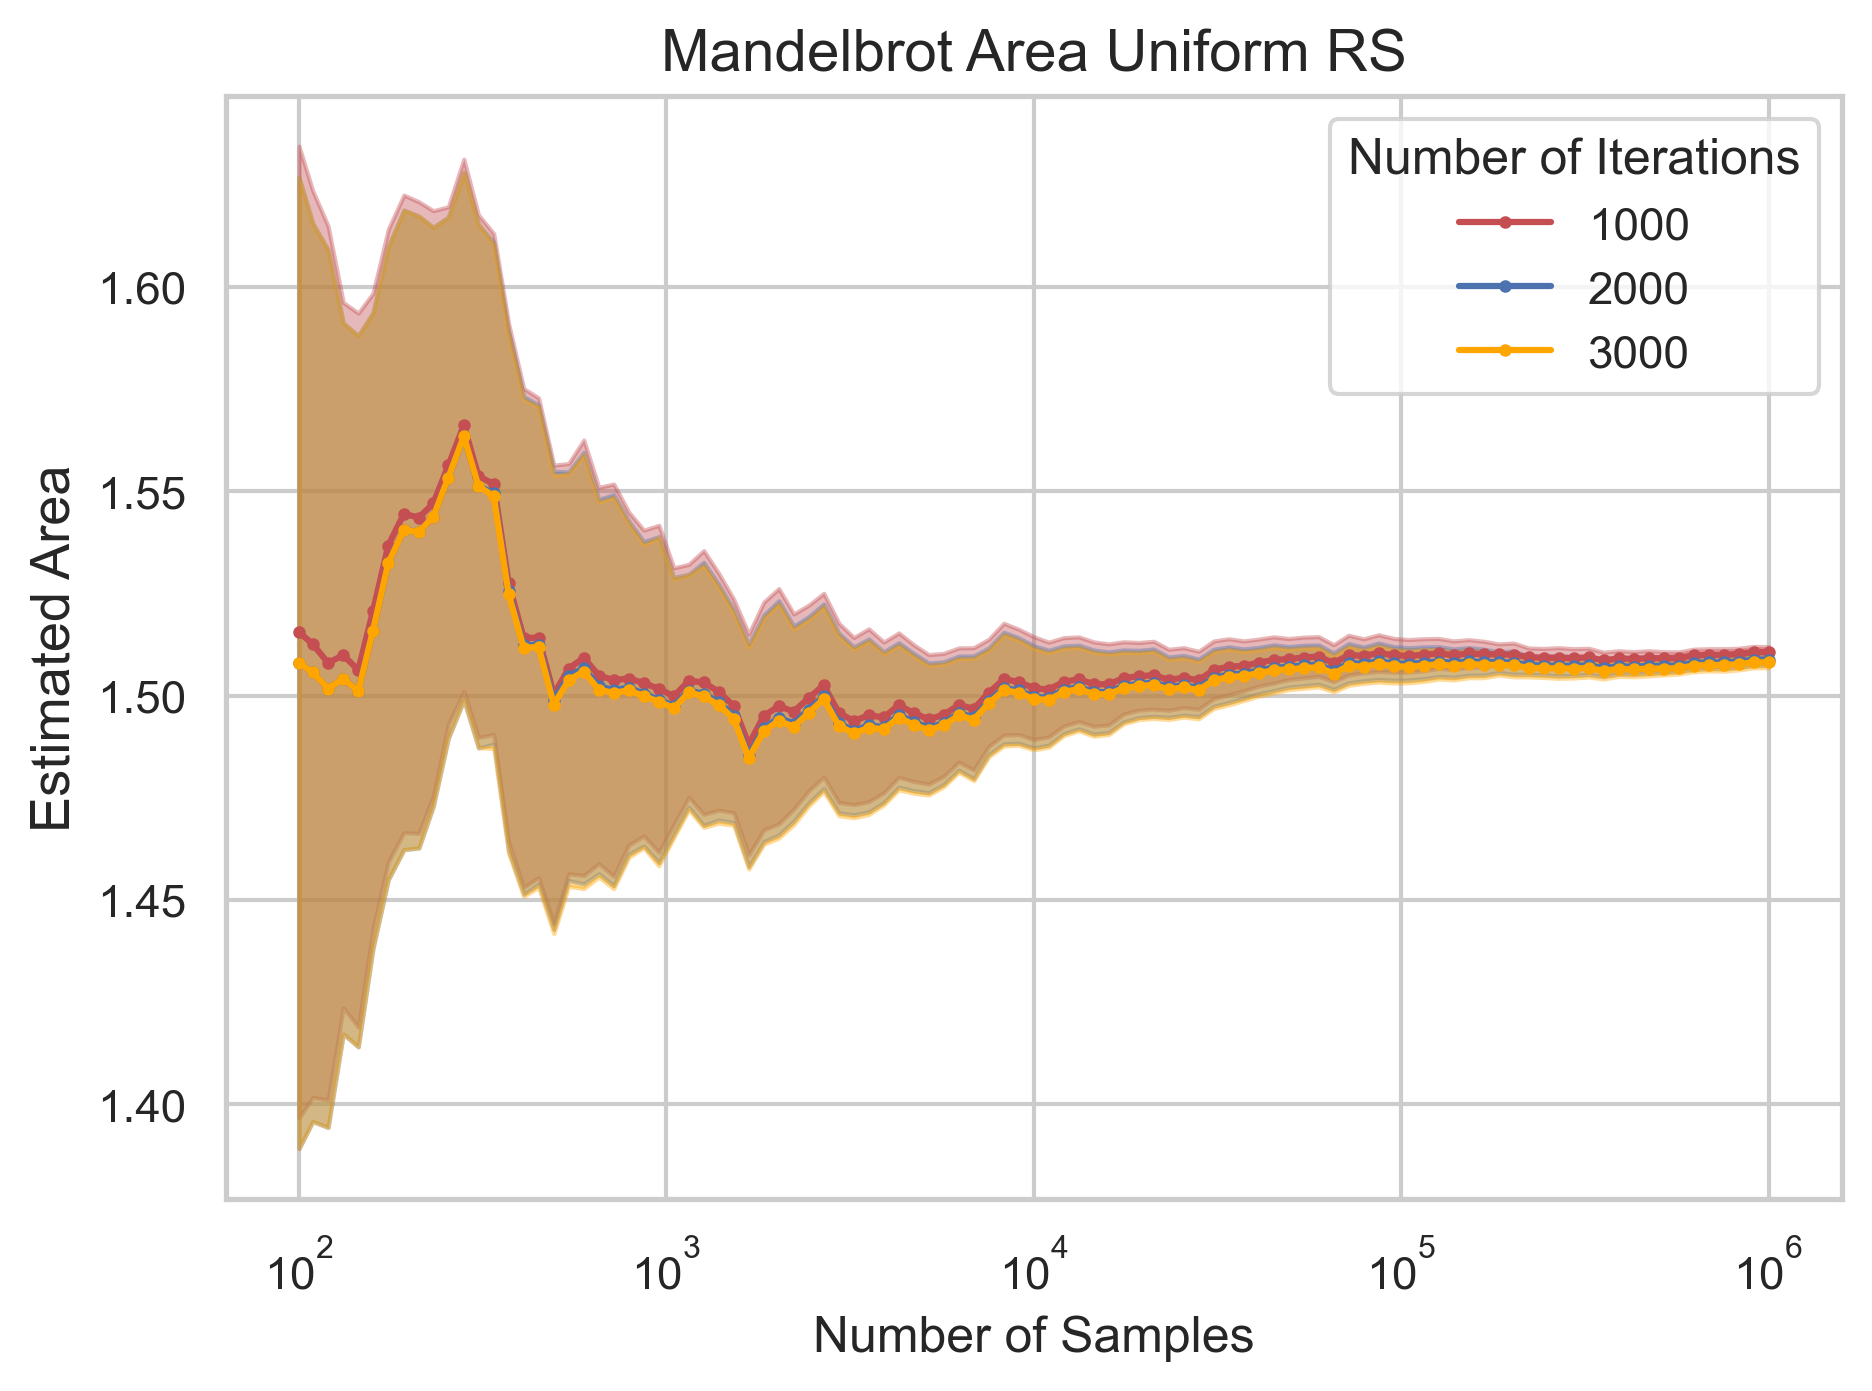

In [14]:
# areas_rs, sd_rs, upper_rs, lower_rs, conv_i_list_rs, grid_rs = get_data_rs(num_mc, i_list, s_list_rs, load_file=True)
i_2000_idx = np.where(i_list == 2000)[0][0]
i_idxs = [0, i_2000_idx, -1]

plot_lineplot(s_list_rs, areas_rs[i_idxs, :], upper_rs[i_idxs, :], lower_rs[i_idxs, :], 'Number of Iterations', i_list[i_idxs], 'RS', fig_filename=f'vary_i_{num_i}_vary_s_{num_s}_{num_mc}_rs')

In [15]:
s_list_lhs = s_list_rs
areas_lhs, sd_lhs, upper_lhs, lower_lhs = get_data_LHS(num_mc, i_list, s_list_lhs, save_file=True)

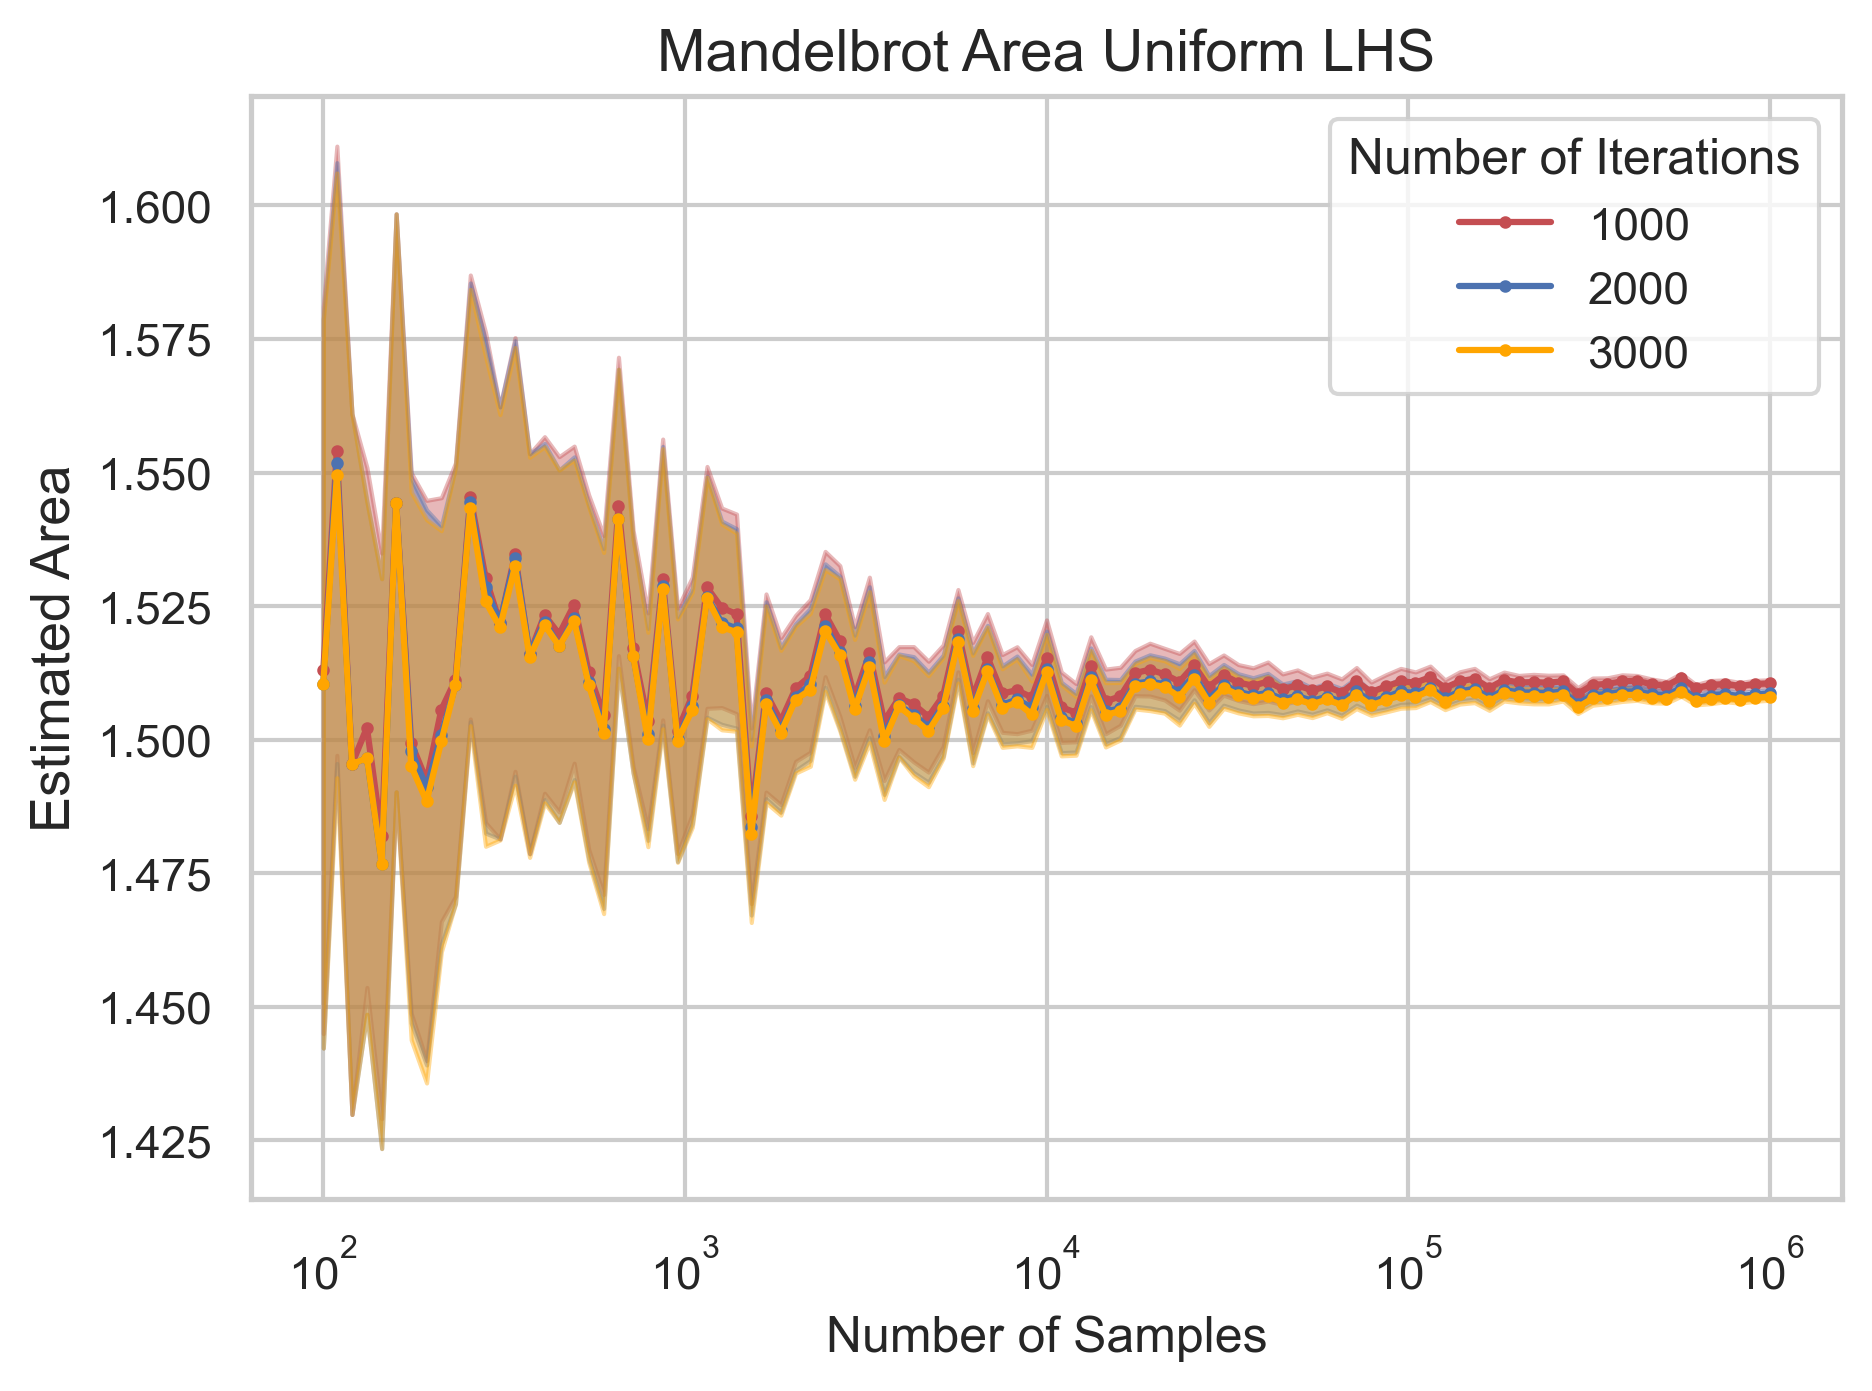

In [16]:
# areas_lhs, sd_lhs, upper_lhs, lower_lhs = get_data_LHS(num_mc, i_list, s_list_lhs, load_file=True)
i_2000_idx = np.where(i_list == 2000)[0][0]
i_idxs = [0, i_2000_idx, -1]

plot_lineplot(s_list_lhs, areas_lhs[i_idxs, :], upper_lhs[i_idxs, :], lower_lhs[i_idxs, :], 'Number of Iterations', i_list[i_idxs], 'LHS', fig_filename=f'vary_i_{num_i}_vary_s_{num_s}_{num_mc}_lhs')

In [17]:
s_list_os = s_list_rs[s_list_rs <= 10**4]
areas_os, sd_os, upper_os, lower_os = get_data_Orth(num_mc, i_list, s_list_os, save_file=True)

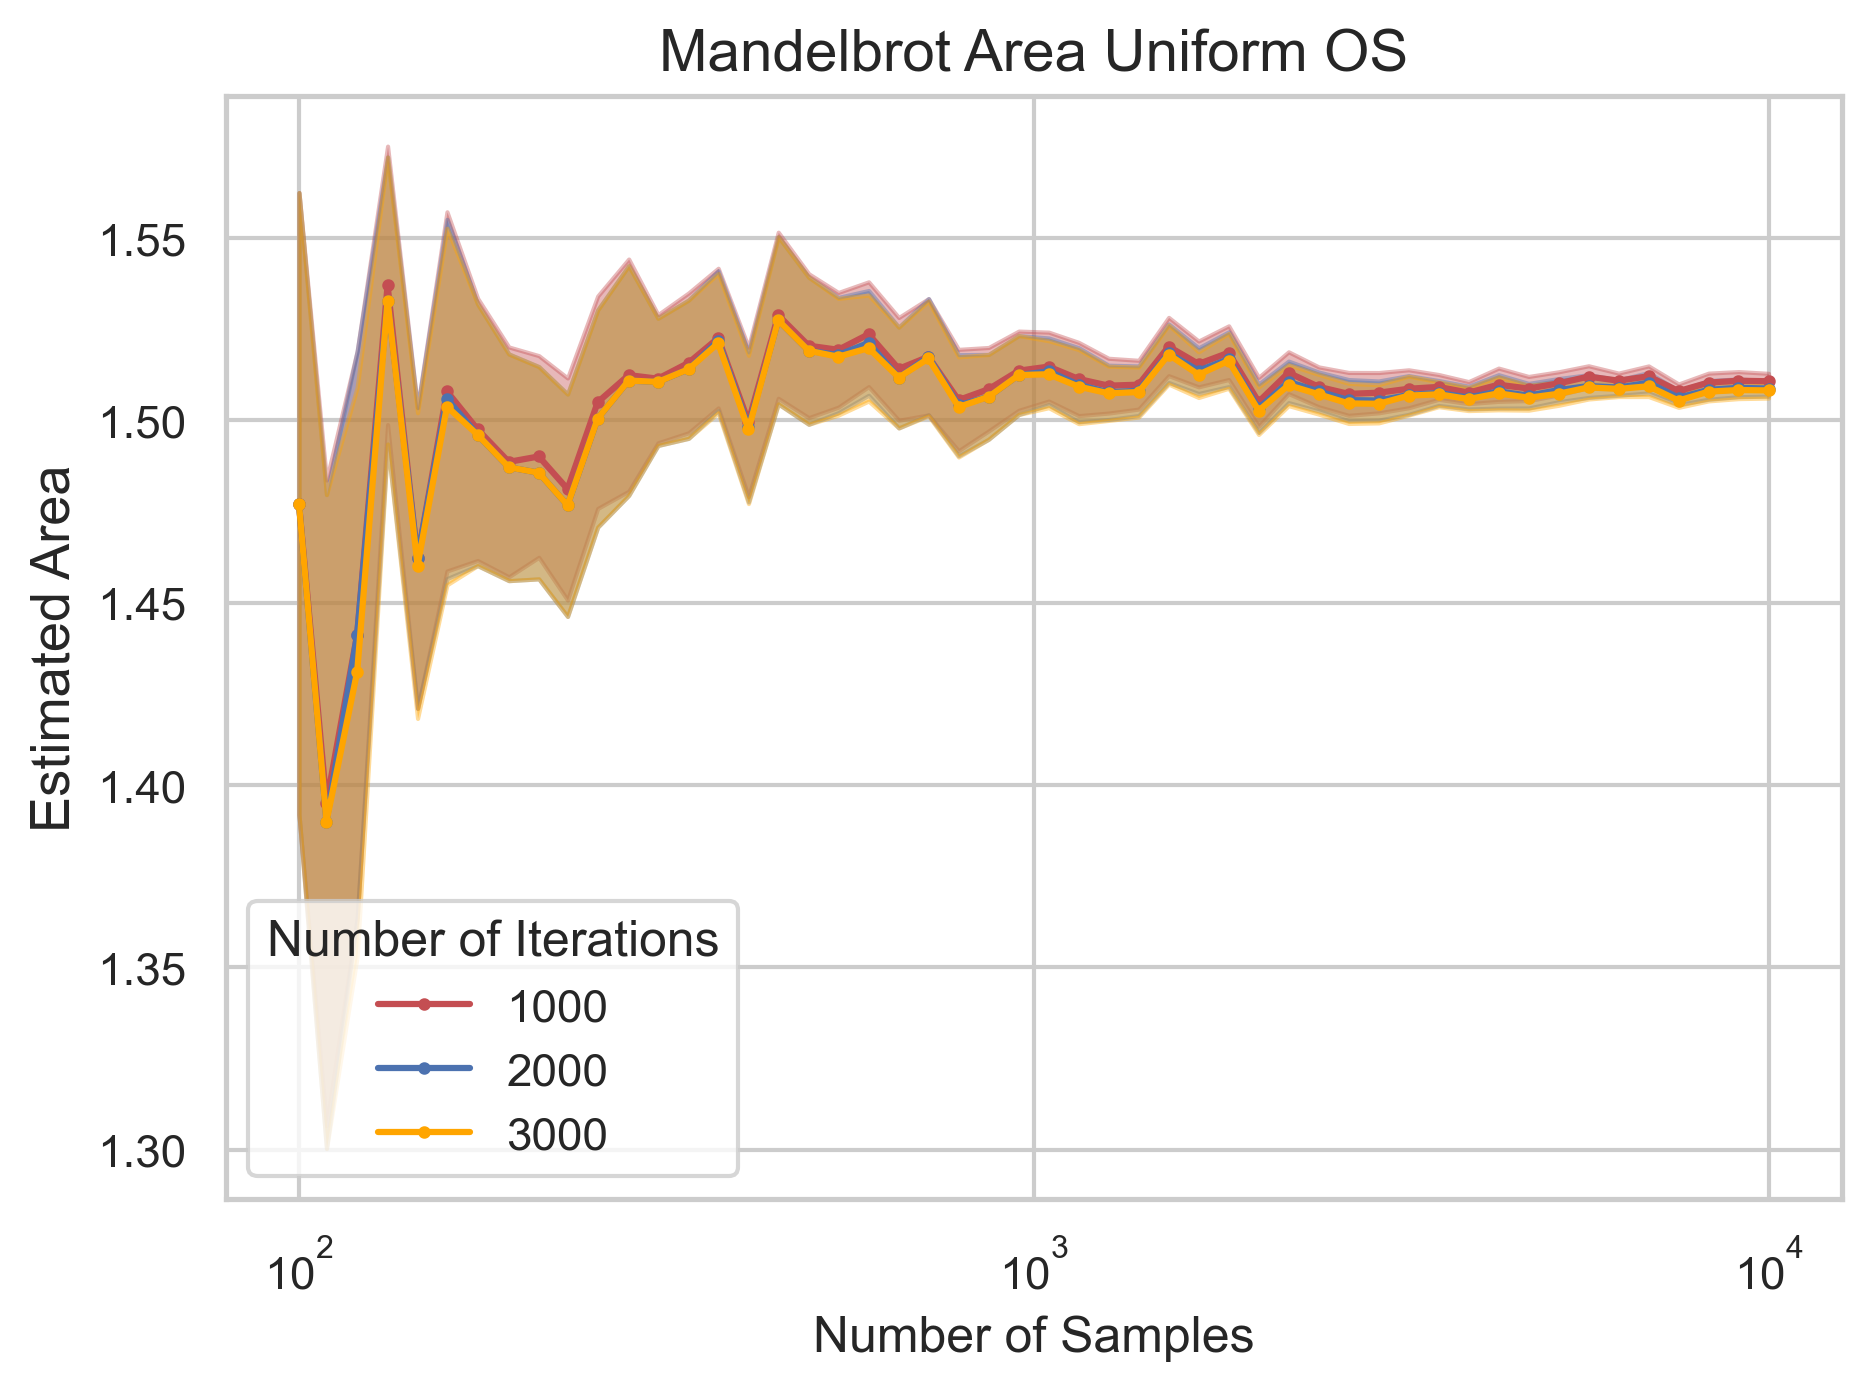

In [20]:
# areas_os, sd_os, upper_os, lower_os = get_data_Orth(num_mc, i_list, s_list_os, save_file=True)
i_2000_idx = np.where(i_list == 2000)[0][0]
i_idxs = [0, i_2000_idx, -1]

plot_lineplot(s_list_os, areas_os[i_idxs, :], upper_os[i_idxs, :], lower_os[i_idxs, :], 'Number of Iterations', i_list[i_idxs], 'OS', fig_filename=f'vary_i_{num_i}_vary_s_{num_s}_{num_mc}_os')

Varying number of iterations with fixed samples size at 10^2, 10^4 and 10^6.

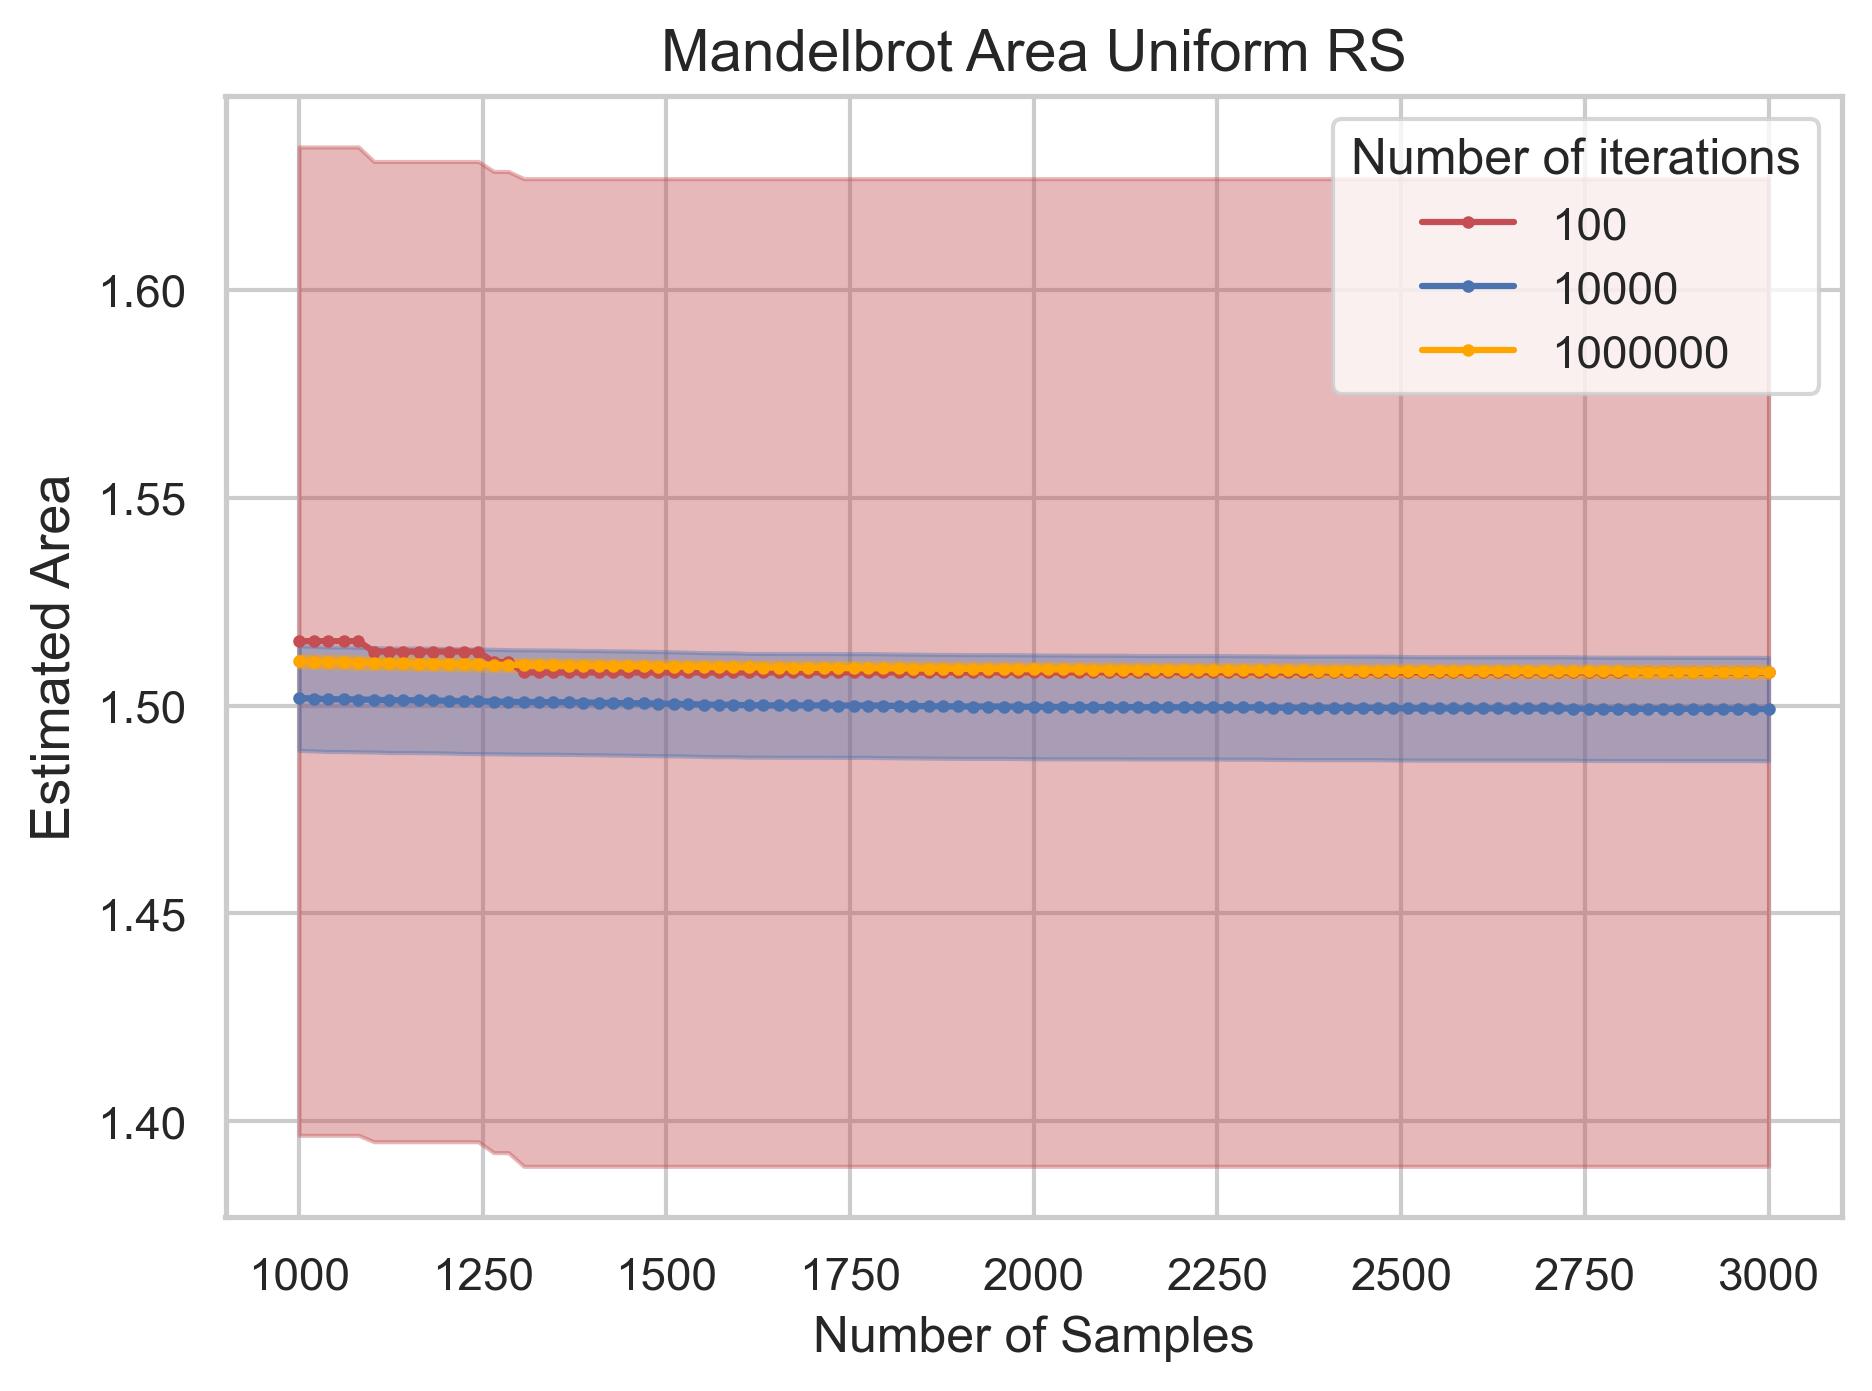

In [26]:
# areas_rs, sd_rs, upper_rs, lower_rs, conv_i_list_rs = get_data_rs(num_mc, i_list, s_list_rs, load_file=True)
s_idx_10_power_4 = np.where(s_list_rs == 10**4)[0][0]
s_idxs = [0, s_idx_10_power_4, -1]

plot_lineplot(i_list, areas_rs[:, s_idxs], upper_rs[:, s_idxs], lower_rs[:, s_idxs], 'Number of iterations', s_list_rs[s_idxs], 'RS', log_x=False, fig_filename=f'vary_s_{num_s}_vary_i_{num_i}_{num_mc}_rs')

1.5081094896399905


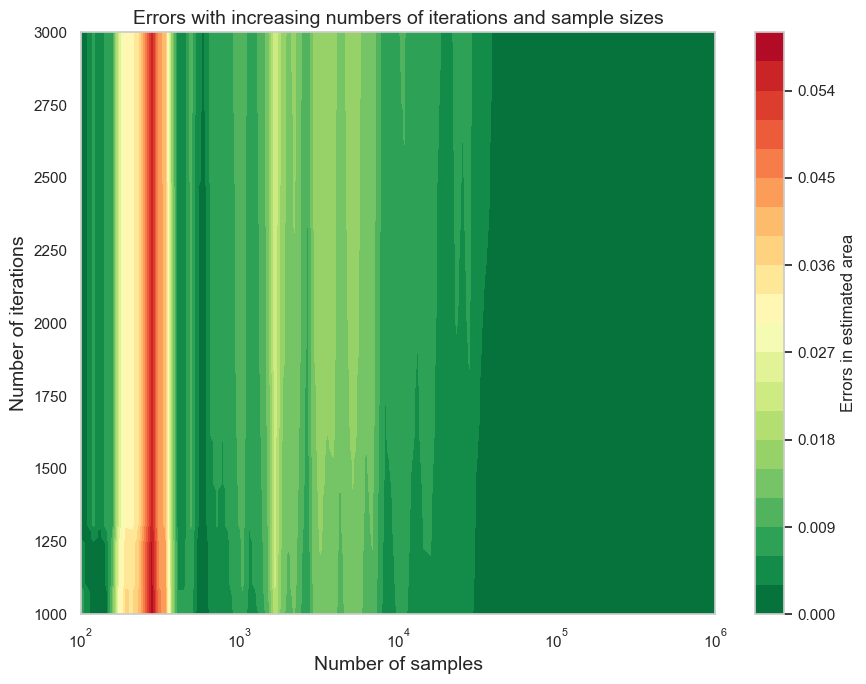

<Figure size 640x480 with 0 Axes>

In [28]:
i_list = np.linspace(1000, 3000, num_i).astype(int)
s_list = np.array([10 ** n for n in np.linspace(2, 6, num_s)]).astype(int)
true_area = areas_rs[-1, -1]
print(true_area)
X,Y = np.meshgrid(s_list, i_list)
plot_heatmap(X,Y, areas_rs, true_area, fig_filename=f'heatmap_vary_s_{num_s}_vary_i_{num_i}_{num_mc}')

# Q3. Rejection Sampling

In [47]:
cos_theta = 1.15/2
theta_2 = np.arccos(cos_theta) * 2
sector = 4*np.pi*(theta_2/(2*np.pi))
trapezoid_2 = (0.5 + np.sqrt(2**2 - 1.1**2)) * 1.1
final_area = sector + trapezoid_2
final_area

6.220130954719004

In [40]:
4*np.pi

12.566370614359172

In [ ]:
def get_data_rejection_sampling_random(grid, converges_i_list, s_list, r=0.5, i=1.1, load_file=None, save_file=None, num_threads=None):
    seed()

    num_i = len(i_list)
    num_s = len(s_list)

    if load_file:
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_areas_{num_mc}_random_rejection.npy', 'rb') as f:
            areas = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_sd_{num_mc}_random_rejection.npy', 'rb') as f:
            sd = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_upper_{num_mc}_random_rejection.npy', 'rb') as f:
            upper_ci = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_lower_{num_mc}_random_rejection.npy', 'rb') as f:
            lower_ci = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_converges_{num_mc}_random_rejection.npy', 'rb') as f:
            converges_i_list_acc= np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_grid_{num_mc}_random_rejection.npy', 'rb') as f:
            grid_acc = np.load(f)

        return areas, sd, upper_ci, lower_ci, converges_i_list_acc, grid_acc
        
    if i_list is None or s_list is None:
        raise ValueError()

    mandelbrot = Mandelbrot()
    areas = np.zeros((num_i, num_s))
    sd = np.zeros((num_i, num_s))
    upper_ci = np.zeros((num_i, num_s))
    lower_ci = np.zeros((num_i, num_s))
    mc_data = None
    
    mask_rejection = ((np.real(grid) <= r) & (np.abs(np.imag(grid)) <= i))
    grid_acc = grid[mask_rejection]
    converges_acc = converges_i_list[:, mask_rejection]
    num_samples_acc = len(grid_acc)
    max_s_idx = len(s_list[s_list <= np.floor(num_samples_acc/num_mc)])

    if save_file:
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_converges_{num_mc}_random_rejection.npy', 'wb') as f:
            np.save(f, converges_acc)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_grid_{num_mc}_random_rejection.npy', 'wb') as f:
            np.save(f, grid_acc)
        
    margin_tbm = stats.t.ppf(0.975, num_mc-1)/np.sqrt(num_mc)

    for s_idx, s in enumerate(s_list[:max_s_idx]):
        with ThreadPoolExecutor(max_workers=num_threads) as ex:
            mc_data = list(ex.map(mandelbrot.get_MC, [converges_i_list[:, s*num:s*(num+1)] for num in np.arange(num_mc)]))

        sd[:, s_idx] = np.std(mc_data, ddof=1, axis=0)
        margin = margin_tbm*sd[:, s_idx]
        areas[:,s_idx] = np.mean(mc_data, axis=0)
        upper_ci[:,s_idx] = areas[:,s_idx] + margin
        lower_ci[:,s_idx] = areas[:,s_idx] - margin
    
    if save_file:
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_areas_{num_mc}_random_rejection.npy', 'wb') as f:
            np.save(f, areas)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_sd_{num_mc}_random_rejection.npy', 'wb') as f:
            np.save(f, sd)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_upper_{num_mc}_random_rejection.npy', 'wb') as f:
            np.save(f, upper_ci)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_lower_{num_mc}_random_rejection.npy', 'wb') as f:
            np.save(f, lower_ci)

    return areas, sd, upper_ci, lower_ci, converges_acc, grid_acc